In [1]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os


# Anna
### Takes an image of a tissue slice and an image of an epithelium extract from Qupath an inputs

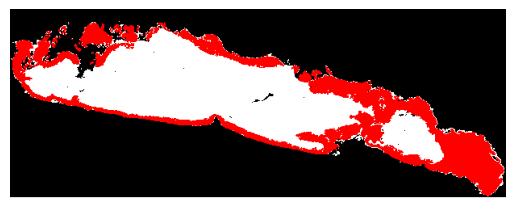

In [2]:
def apply_mask():

    # Open the JPG and PNG images
    jpg_path = '/Users/annaroney/Downloads/Stat390_Anna/QuPath_work/1:22 patching test/data/2/thumbnail.jpg' # path to the tissue slice
    png_mask_path = '/Users/annaroney/Downloads/Stat390_Anna/QuPath_work/1:22 patching test/export/h1857578B  h&e_ROI_2-labels.png' # path to the epithelium slice
    
    jpg_image = Image.open(jpg_path).convert("RGB")
    png_mask = Image.open(png_mask_path).convert("RGBA")

    # Resize the mask to match the JPG dimensions if they differ
    if jpg_image.size != png_mask.size:
        png_mask = png_mask.resize(jpg_image.size, Image.LANCZOS)

    # Convert both images to numpy arrays
    jpg_array = np.array(jpg_image)
    mask_array = np.array(png_mask)

    # Create a mask for the PNG: True where the PNG is not white
    non_white_mask = ~np.all(mask_array[:, :, :3] > 200, axis=-1)  # Mask where PNG is not white

    # Create the final output image with a black background
    final_image_array = np.zeros_like(jpg_array)

    # Add white for stroma: Original white pixels in the JPG
    stroma_mask = np.all(jpg_array > 200, axis=-1)  # White pixels in JPG
    final_image_array[stroma_mask] = [0, 0, 0]  # Set stroma to white

    # Add red for mask: Areas in the PNG mask
    final_image_array[non_white_mask] = [254, 0, 0]  # Set mask areas to red
    mask = final_image_array
    # Set remaining original JPG pixels (not covered by PNG) to black
    non_masked_area = ~(stroma_mask | non_white_mask)  # Pixels not in stroma or mask
    final_image_array[non_masked_area] = [255, 255, 255]  # Set uncovered pixels to black

    # Convert back to PIL image
    final_image = Image.fromarray(final_image_array)

    return final_image, mask


   

image, mask = apply_mask()
filename = '/Users/annaroney/Downloads/Stat390_Anna/QuPath_work/1:22 patching test/epitheliums.png' # where you want your output to go
image.save(filename)

# Display the final image
plt.imshow(image)
plt.axis("off")
plt.show()

mask[mask == 255] = 0 


# Alyssa  Patching Code

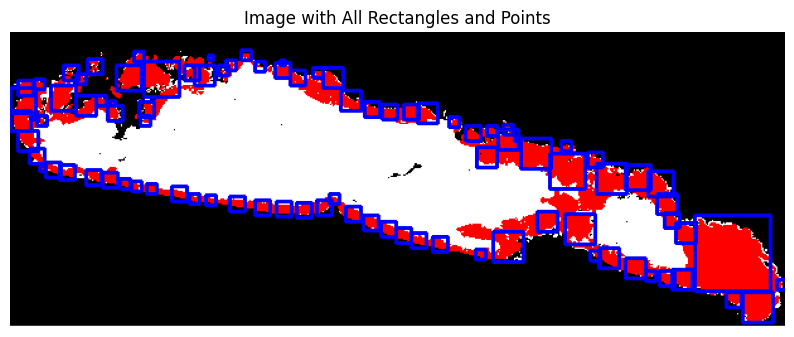

In [3]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# Load the image
image_path = '/Users/annaroney/Downloads/Stat390_Anna/QuPath_work/1:22 patching test/epitheliums.png' 
image = cv2.imread(image_path)

# Function to check if a region contains black, white, and non-black-white mask
# function is not called?
def contains_black_white_mask(region):
    contains_black = np.any(np.all(region == [0, 0, 0], axis=-1))
    contains_white = np.any(np.all(region == [255, 255, 255], axis=-1))
    contains_mask = np.any((region != [0, 0, 0]).all(axis=-1) & (region != [255, 255, 255]).all(axis=-1))
    return contains_black and contains_white and contains_mask

# Mask for black areas, white areas, and non-black-white pixels
black_mask = cv2.inRange(image, np.array([0, 0, 0]), np.array([0, 0, 0]))
white_mask = cv2.inRange(image, np.array([255, 255, 255]), np.array([255, 255, 255]))
non_black_white_mask = mask

# Calculate distance to the nearest black and white pixels
black_distance = cv2.distanceTransform(255 - black_mask, cv2.DIST_L2, 3)
white_distance = cv2.distanceTransform(255 - white_mask, cv2.DIST_L2, 3)

# Find coordinates of non-black and non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Define the ratio tolerance range for balanced points
min_ratio, max_ratio = 0.7, 1.3

# Filter coordinates to only include balanced points
balanced_points = [
    coord for coord in coordinates
    if min_ratio <= (black_distance[coord[0], coord[1]] / white_distance[coord[0], coord[1]]) <= max_ratio
]

# Define max attempts and initial size parameters
max_attempts = 1000
initial_size = 2
covered_coordinates = set()
rectangles = []
attempts = 0

# Function to calculate overlap
def calculate_overlap(new_coords, existing_coords):
    overlap = len(new_coords.intersection(existing_coords)) / len(new_coords)
    return overlap

# Start generating squares using only balanced points as starting locations
while len(balanced_points) > 0 and attempts < max_attempts:
    attempts += 1
    # Randomly select a new center point for the square from balanced points
    random.seed(attempts) # Anna added
    random_coord = random.choice(balanced_points)
    center_x, center_y = int(random_coord[1]), int(random_coord[0])
    num_squares_drawn = 0
    vertical_preference = False

    # Expansion phase for square
    while True:
        size = initial_size * (num_squares_drawn + 1)
        top, bottom = center_y - size, center_y + size
        left, right = center_x - size, center_x + size

        # Define regions at each corner of the square
        corner_checks = {
            "top_left": (top, left),
            "top_right": (top, right - initial_size),
            "bottom_left": (bottom - initial_size, left),
            "bottom_right": (bottom - initial_size, right - initial_size)
        }

        # Track how many corners are outside the mask
        corners_outside_count = 0

        # Check each corner and determine if it is outside the mask
        for corner_name, (corner_y, corner_x) in corner_checks.items():
            # Ensure the region is within the image bounds
            if corner_y < 0 or corner_x < 0 or corner_y + initial_size > image.shape[0] or corner_x + initial_size > image.shape[1]:
                corners_outside_count += 1
                continue

            # Extract the corner region in the mask at this corner
            corner_region = non_black_white_mask[corner_y:corner_y + initial_size, corner_x:corner_x + initial_size]
            
            # If all pixels in the corner region are black, mark this corner as outside the mask
            if not np.any(corner_region):
                corners_outside_count += 1
            

            # Stop checking if we already have two corners outside
            if corners_outside_count >= 2:
                break

        # Stop expanding if at least two corners are outside the mask
        if corners_outside_count >= 2:
            # Check if the region shape requires a vertical rectangle
            if (bottom - top) > (right - left) * 1.5:
                vertical_preference = True
            break  # Stop expanding as it satisfies the mask requirements

        # Increment the number of squares drawn to expand further
        num_squares_drawn += 1
        if num_squares_drawn > 15:  # Limit expansion if square becomes too large
            break

    # Get all coordinates in the current square
    new_square_coords = set((y, x) for y in range(max(0, top), min(image.shape[0], bottom))
                                    for x in range(max(0, left), min(image.shape[1], right)))

    # Check overlap with existing covered coordinates
    if calculate_overlap(new_square_coords, covered_coordinates) <= 0.2:
        covered_coordinates.update(new_square_coords)
        rectangles.append((left, top, right, bottom))
        
        # Draw the rectangle
        color = (0, 255, 0) if vertical_preference else (255, 0, 0)
        cv2.rectangle(image, (left, top), (right, bottom), color, 2)

        # Remove these coordinates from the non-black-white mask list and balanced points
        coordinates = np.array([coord for coord in coordinates if tuple(coord) not in new_square_coords])
        balanced_points = [coord for coord in balanced_points if tuple(coord) not in new_square_coords]

# Display the resulting image with all rectangles
plt.figure(figsize=(10, 10))
plt.title("Image with All Rectangles and Points")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

lengths = []

# Print dimensions of each final rectangle as Length x Width
for i, (left, top, right, bottom) in enumerate(rectangles, 1):
    length = bottom - top  # Height of the rectangle
    width = right - left   # Width of the rectangle
    lengths.append(length)
    
    #print(f"Rectangle {i} dimensions: Length = {length} pixels, Width = {width} pixels")



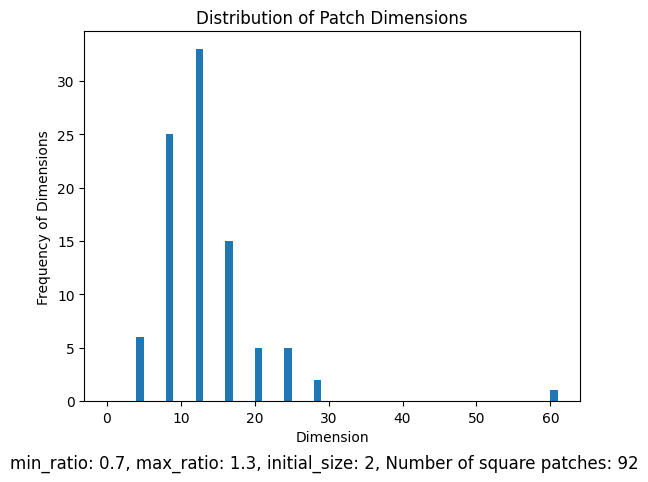

In [86]:
plt.hist(lengths, bins = np.arange(0, max(lengths)+2))
plt.xlabel('Dimension')
plt.ylabel('Frequency of Dimensions')
plt.title('Distribution of Patch Dimensions')
plt.suptitle(f"min_ratio: {min_ratio}, max_ratio: {max_ratio}, initial_size: {initial_size}, Number of square patches: {len(lengths)}", y=0)
plt.show()


# only have extracted one image so far but in future this will be a graph of patch dimension data for all images combined
